In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 
import seaborn as sns
import pynbody
from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.utils.data as data
from torch.distributions.normal import Normal
from torch.distributions.uniform import Uniform

# Data

In [2]:
def generate_mixture_of_gaussians(num_of_points):
    n = num_of_points//3
    gaussian1 = np.random.normal(loc=-1, scale=0.25, size=(n,))
    gaussian2 = np.random.normal(loc=1.5, scale=0.35, size=(n,))
    gaussian3 = np.random.normal(loc=0.0, scale=0.2, size=(num_of_points-2*n, ))
    return np.concatenate([gaussian1, gaussian2, gaussian3])

class NumpyDataset(data.Dataset):
    def __init__(self, array):
        super().__init__()
        self.array = array
        
    def __len__(self):
        return len(self.array)
    
    def __getitem__(self, index):
        return self.array[index]
    
n_train, n_test = 2000, 1000
train_data = generate_mixture_of_gaussians(n_train)
test_data  = generate_mixture_of_gaussians(n_test)


train_loader = data.DataLoader(NumpyDataset(train_data), batch_size=128, shuffle=True)
test_loader  = data.DataLoader(NumpyDataset(test_data), batch_size=128, shuffle=True)

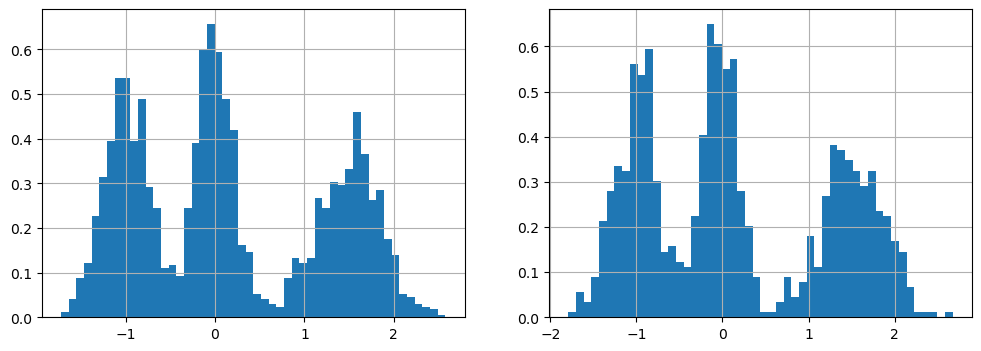

In [3]:
_, axes = plt.subplots(1, 2, figsize=(12,4))
_ = axes[0].grid(), axes[1].grid()
_ = axes[0].hist(train_data, bins=50, density=True)
_ = axes[1].hist(test_data, bins=50, density=True)

# Model

In [4]:
class Flow1d(nn.Module):
    def __init__(self, n_compontents):
        super(Flow1d, self).__init__()
        self.mus = nn.Parameter(torch.randn(n_compontents), requires_grad=True)
        self.log_sigmas = nn.Parameter(torch.zeros(n_compontents), requires_grad=True)
        self.weight_logits = nn.Parameter(torch.ones(n_compontents), requires_grad=True)
    
    def forward(self, x):
        x = x.view(-1, 1)
        weights = self.weight_logits.softmax(dim=0).view(1, -1)
        distribution = Normal(self.mus, self.log_sigmas.exp())
        z = (distribution.cdf(x) * weights).sum(dim=1)
        log_dz_by_dx = (distribution.log_prob(x).exp() * weights).sum(dim=1).log()
        return z, log_dz_by_dx

class LogitTransform(nn.Module):
    def __init__(self, alpha):
        super(LogitTransform, self).__init__()
        self.alpha = alpha
    
    def forward(self, x):
        x_new = self.alpha/2 + (1-self.alpha)*x
        z = torch.log(x_new) - torch.log(1-x_new)
        log_dz_by_dx = torch.log(torch.FloatTensor([1-self.alpha])) - torch.log(x_new) - torch.log(1-x_new) 
        return z, log_dz_by_dx

class FlowComposable1d(nn.Module):
    def __init__(self, flow_model_list):
        super(FlowComposable1d, self).__init__()
        self.flow_model_list = nn.ModuleList(flow_model_list)
        
    def forward(self, x):
        z, sum_log_dz_by_dx = x, 0
        for flow in self.flow_model_list:
            z, log_dz_by_dx = flow(z)
            sum_log_dz_by_dx += log_dz_by_dx
        return z, sum_log_dz_by_dx

# Training and evaluating routine

In [5]:
def loss_function(target_distribution, z, log_dz_by_dx):
    log_likelihood = target_distribution.log_prob(z) + log_dz_by_dx
    return -log_likelihood.mean()

def train(model, train_loader, optimizer, target_distribution):
    model.train()
    for x in train_loader:
        z, log_dz_by_dx = model(x)
        loss = loss_function(target_distribution, z, log_dz_by_dx)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

def eval_loss(model, data_loader, target_distribution):
    model.eval()
    total_loss=0
    for x in data_loader:
        z, log_dz_by_dx = model(x)
        loss = loss_function(target_distribution, z, log_dz_by_dx)
        total_loss += loss * x.size(0)
    return (total_loss / len(data_loader.dataset)).item()

def train_and_eval(epochs, lr, train_loader, test_loader, targe_distribution):
    flow_model_list = [Flow1d(2), LogitTransform(0.1), Flow1d(2), LogitTransform(0.1), Flow1d(2)]
    flow = FlowComposable1d(flow_model_list)
    optimizer = torch.optim.Adam(flow.parameters(), lr)
    train_losses, test_losses = [], []
    for epoch in tqdm(range(epochs)):
        train(flow, train_loader, optimizer, target_distribution)
        train_losses.append(eval_loss(flow, train_loader, target_distribution))
        test_losses.append(eval_loss(flow, test_loader, target_distribution))
    return flow, train_losses, test_losses

# Training 

## Plot training and test data

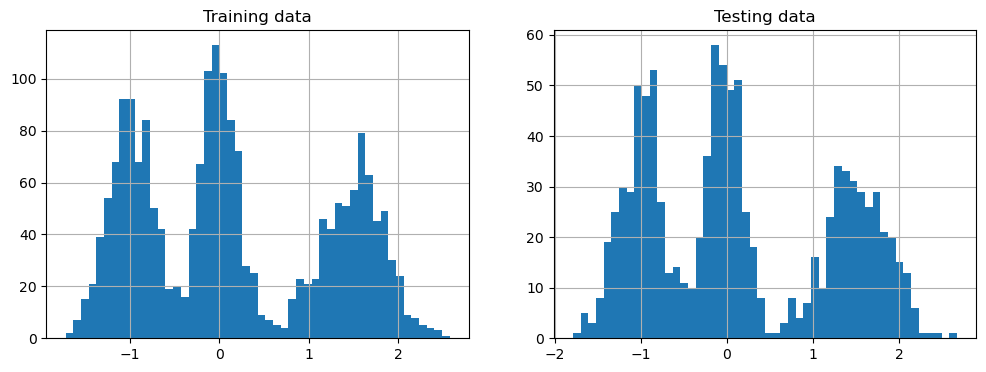

In [6]:
_, axes = plt.subplots(1,2, figsize=(12, 4))
_ = axes[0].hist(train_loader.dataset.array, bins=50)
_ = axes[1].hist(test_loader.dataset.array, bins=50)
_ = axes[0].set_title('Training data')
_ = axes[1].set_title('Testing data')
_ = axes[0].grid(), axes[1].grid()

## train the composable flow model

In [7]:
target_distribution = Uniform(0, 1)
flow, train_losses, test_losses = train_and_eval(150, 1e-2, 
                                                train_loader, 
                                                test_loader,
                                                target_distribution)

100%|█████████████████████████████████████████████████████████████████████| 150/150 [00:12<00:00, 12.23it/s]


## Losses

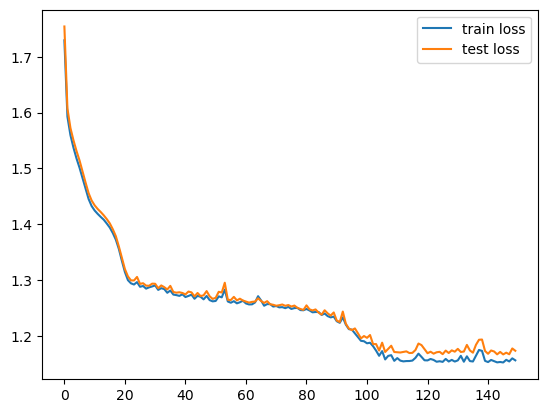

In [8]:
_ = plt.plot(train_losses, label='train loss')
_ = plt.plot(test_losses,  label='test loss')
plt.legend()

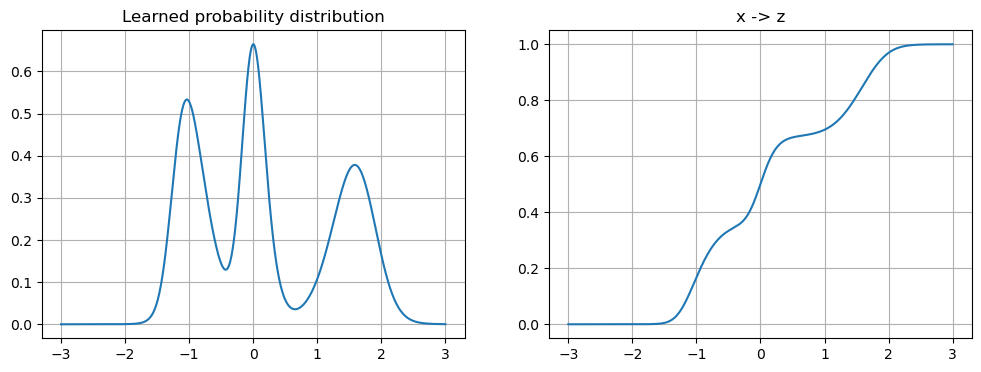

In [9]:
x = np.linspace(-3, 3, 1000)
with torch.no_grad():
    z, log_dz_by_dx = flow(torch.FloatTensor(x))
    px = (target_distribution.log_prob(z) + log_dz_by_dx).exp()
    
_, axes = plt.subplots(1,2, figsize=(12,4))
_ = axes[0].grid(), axes[1].grid()
_ = axes[0].plot(x,px)
_ = axes[0].set_title('Learned probability distribution')

_ = axes[1].plot(x,z)
_ = axes[1].set_title('x -> z')

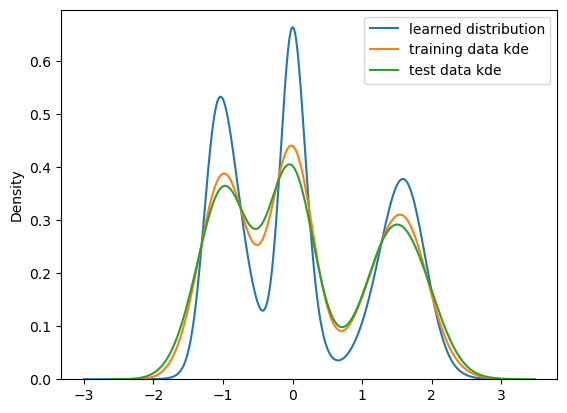

In [10]:
plt.plot(x, px, label='learned distribution')
sns.kdeplot(train_data, label='training data kde')
sns.kdeplot(test_data, label='test data kde')
plt.legend();

# Training on simulation data

Text(0.5, 0, 'Fe/H')

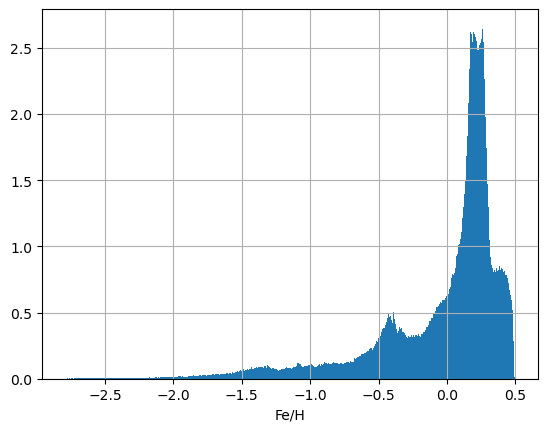

In [11]:
s = pynbody.load('data/g8.26e11/snap_2000/output/8.26e11.02000')
h = s.halos()

feh_array = np.array(s.s['feh'])
feh_array = feh_array[feh_array > np.percentile(feh_array, 0.1)]

plt.hist(feh_array, bins='sqrt', density=True)
plt.grid()
plt.xlabel('Fe/H')

In [12]:
#data loader
train_data, test_data = train_test_split(feh_array, train_size=0.67, shuffle=True)

train_loader = data.DataLoader(NumpyDataset(train_data), batch_size=128, shuffle=True)
test_loader = data.DataLoader(NumpyDataset(test_data), batch_size=128, shuffle=True)

In [13]:
target_distribution = Uniform(0.0, 1.0)
flow, train_losses, test_losses = train_and_eval(50, 1e-2,
                                                 train_loader,
                                                 test_loader, 
                                                 target_distribution)

100%|████████████████████████████████████████████████████████████████████| 50/50 [1:43:49<00:00, 124.60s/it]


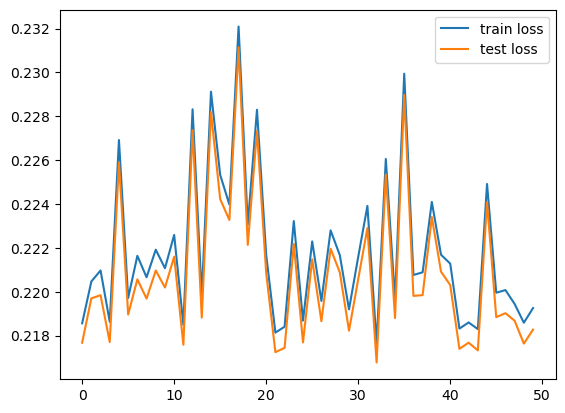

In [16]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend();

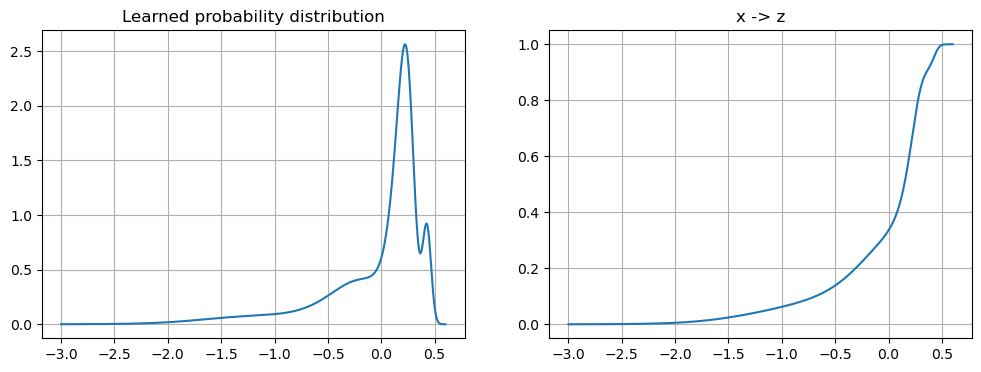

In [15]:
x = np.linspace(-3, 0.6, 1000)
with torch.no_grad():
    z, log_dz_by_dx = flow(torch.FloatTensor(x))
    px = (target_distribution.log_prob(z) + log_dz_by_dx).exp()
    
_, axes = plt.subplots(1,2, figsize=(12,4))
_ = axes[0].grid(), axes[1].grid()
_ = axes[0].plot(x,px)
_ = axes[0].set_title('Learned probability distribution')

_ = axes[1].plot(x,z)
_ = axes[1].set_title('x -> z')

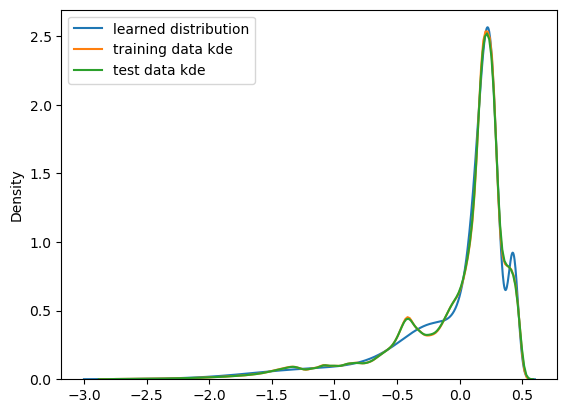

In [17]:
plt.plot(x, px, label='learned distribution')
sns.kdeplot(train_data, label='training data kde')
sns.kdeplot(test_data, label='test data kde')
plt.legend();